### PSATITP

In [1]:
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from xgboost import XGBRegressor

from data_import import import_precipitation_ts, get_plants
from data_analysis import  is_stationary, plot_acf_pacf, precipitation_plots
from prediction import cross_validation, test
from split import split_train_test_by_size

### Importing data

In [2]:
ts_dict = import_precipitation_ts()
plants = get_plants()
plant_on_analysis = "PSATITP"

### Data Analysis


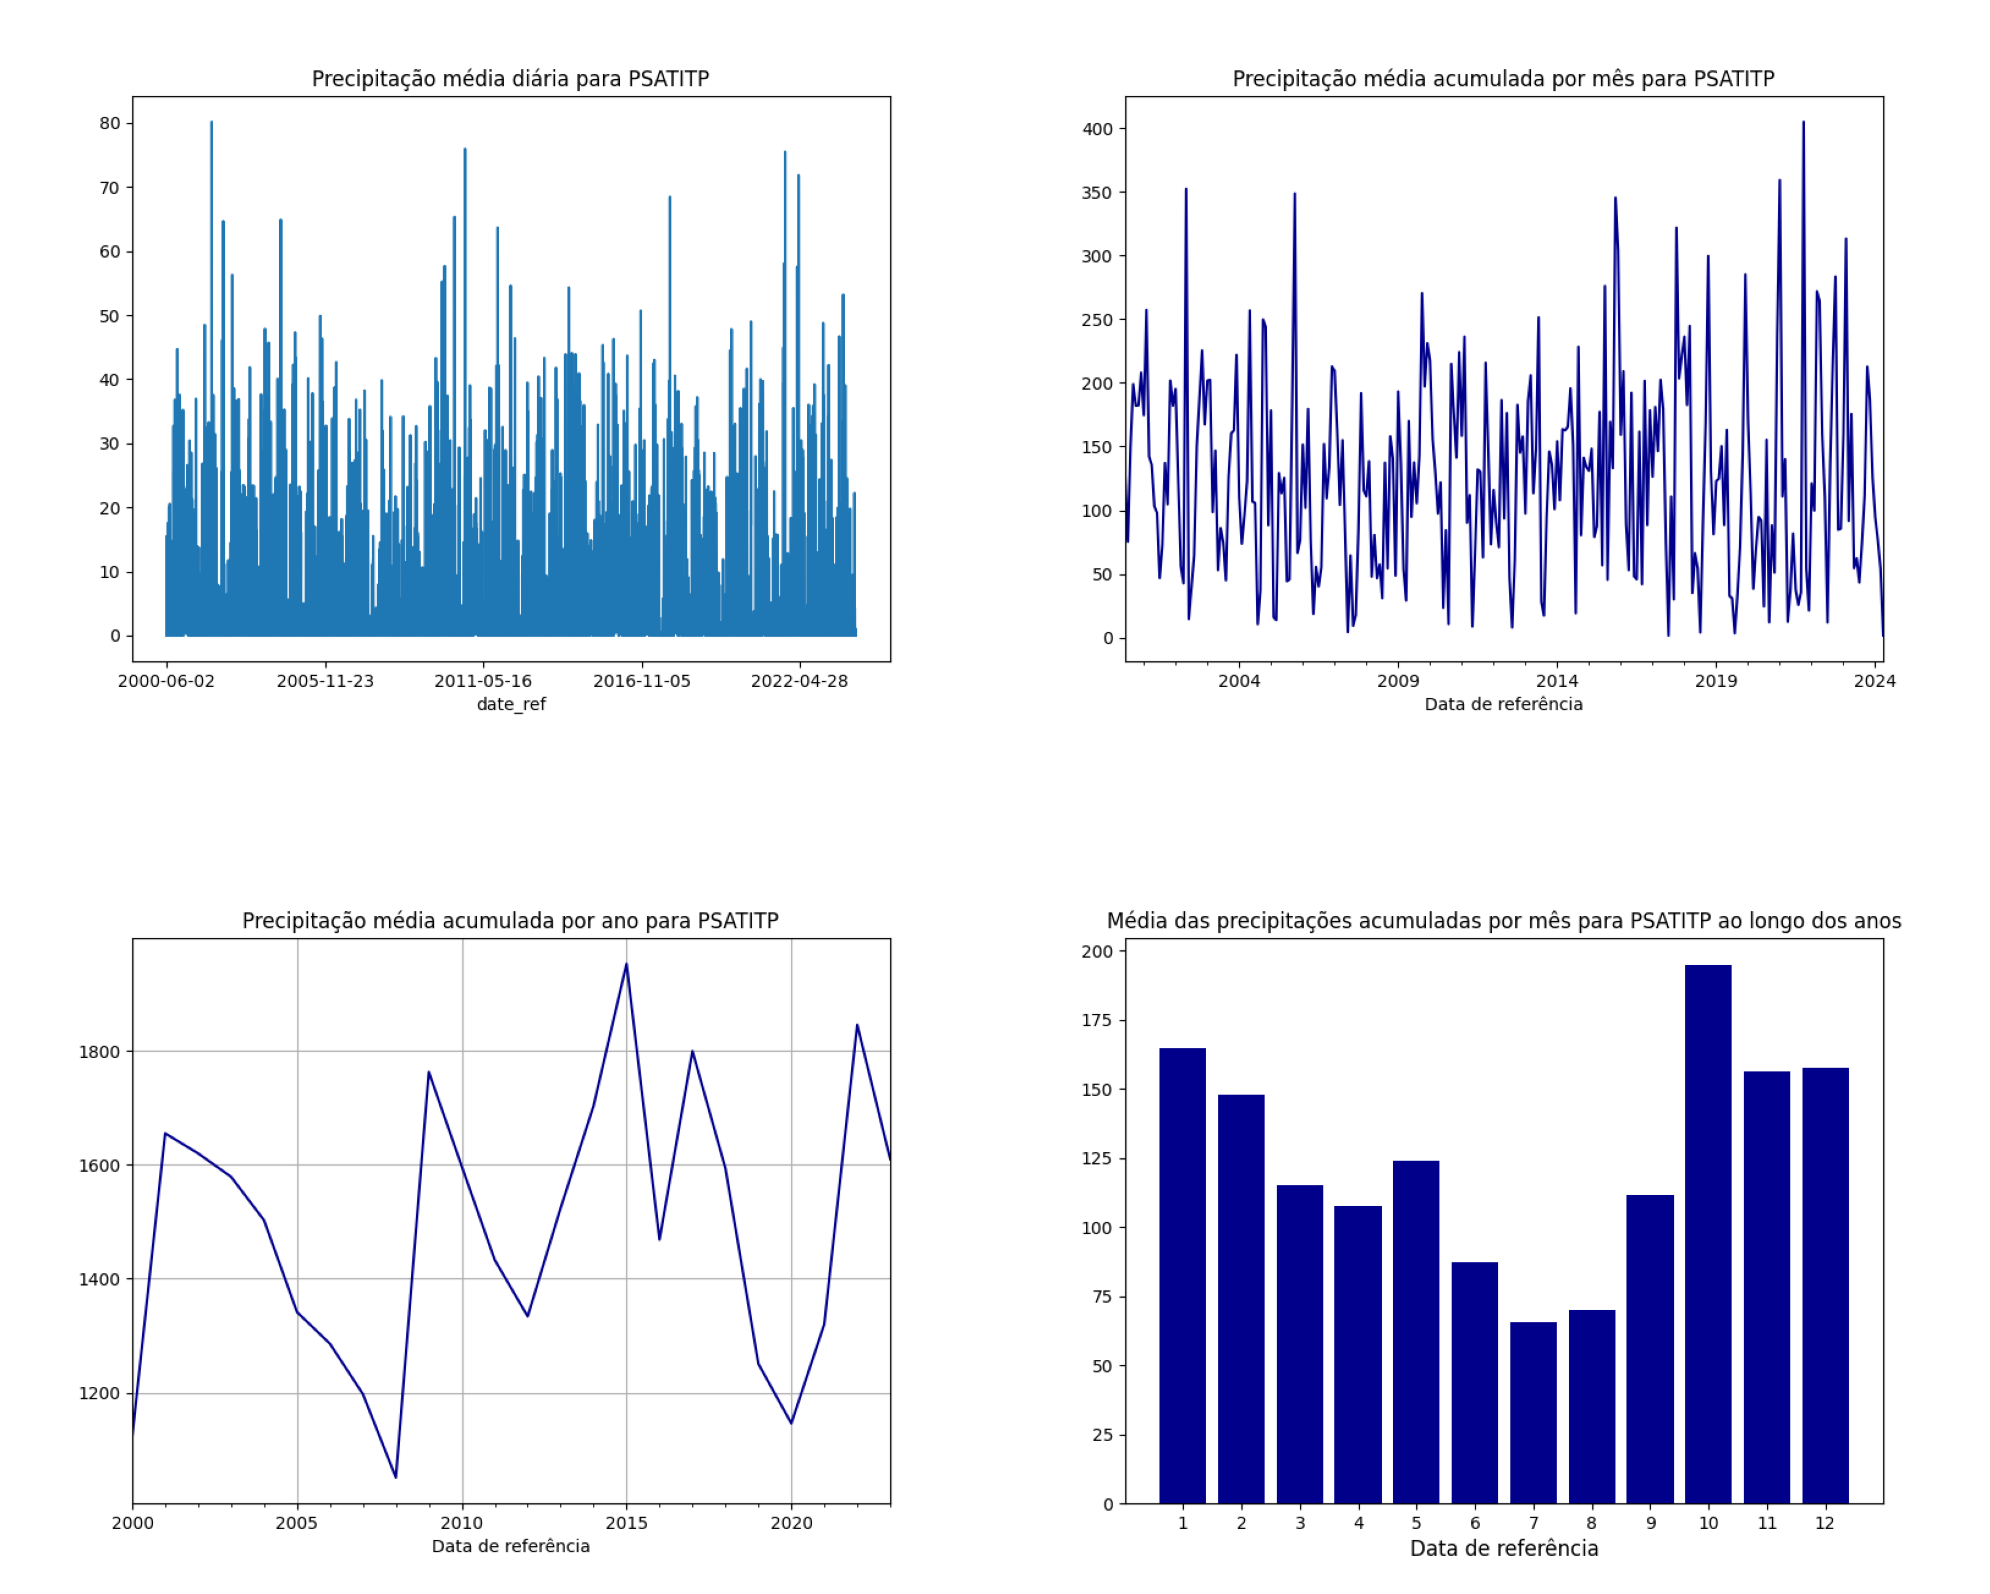

In [3]:
precipitation_plots(ts_dict, plant_on_analysis)

In [4]:
is_stationary(ts_dict, "PSATITP")

+---------------+------------+------------+------------+
|               |   Normal   |    Diff    |  LogDiff   |
+---------------+------------+------------+------------+
| ADF Statistic |   -15.36   |   -24.23   |   -21.96   |
|    p-value    |    0.00    |    0.00    |    0.00    |
|    result     | Stationary | Stationary | Stationary |
+---------------+------------+------------+------------+


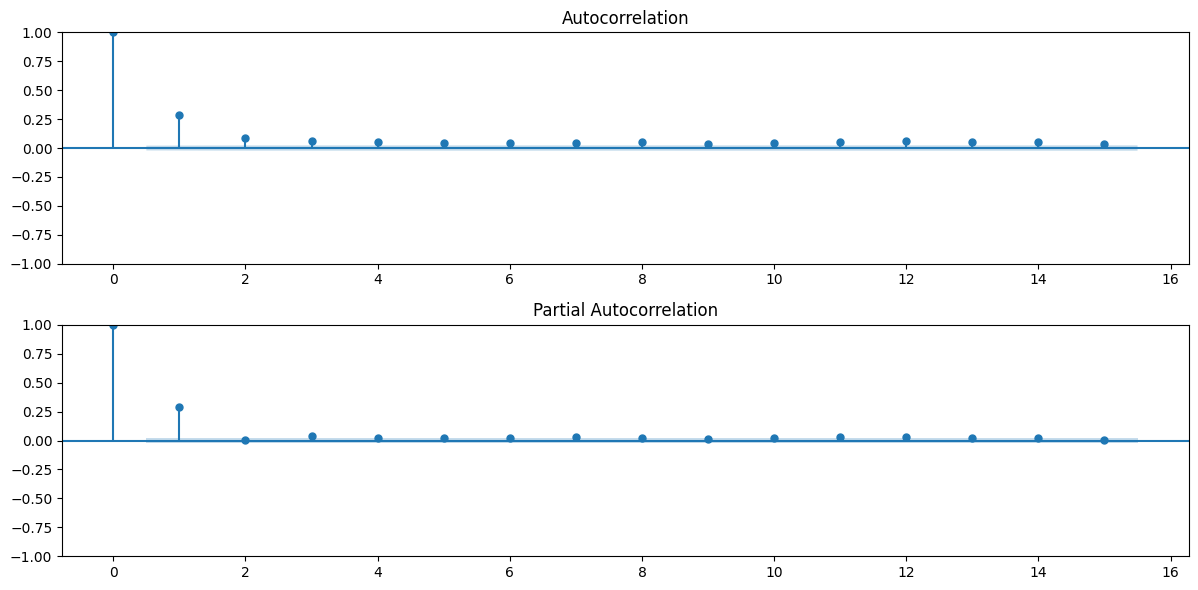

In [5]:
plot_acf_pacf(ts_dict, "PSATITP")

### Preparing Data for Prediction

In [6]:
df = ts_dict[plant_on_analysis].dropna(axis=0)
X_train, X_test, y_train, y_test = split_train_test_by_size(df, 100)

In [7]:
dfcg = df.copy()
c = pd.read_csv(f"../data/ts-{plant_on_analysis}-cfs-model.csv", index_col=[0])
g = pd.read_csv(f"../data/ts-{plant_on_analysis}-gefs-model.csv", index_col=[0])
dfcg = pd.concat([dfcg, c, g], axis=1).dropna(axis=0)
X_cg_train, X_cg_test, y_cg_train, y_cg_test = split_train_test_by_size(dfcg)

mask = np.ones(X_cg_train.shape[1], dtype=bool)
mask[15:30] = False # lag 16 to 30
mask[30:45] = False # lag 31 to 45
# mask[45:58] = False # 11 months and 2 means
mask[58:73] = False # lag 31 to 45 from cfs
mask[73:88] = False # lag 16 to 30 from cfs
# mask[88:103] = False # lag 15 1 30 from cfs
# mask[103:118] = False # lag 15 to 1 from gefs
X_cg_train = X_cg_train.loc[:, mask]
X_cg_test = X_cg_test.loc[:, mask]
X_cg_train = X_cg_train.astype({f"m_{i}": bool for i in range(2, 13)})
X_cg_test = X_cg_test.astype({f"m_{i}": bool for i in range(2, 13)})

### Hyperparameters search

In [8]:
tscv = TimeSeriesSplit(n_splits=5)

In [9]:
param_grid_knn = {
    'n_neighbors': range(1, 15),
    'p': [1, 2, 3],
}

param_grid_rf = {
    'n_estimators': [20, 50, 80, 100, 150, 200],
    'max_depth': [3, 4, 5, 6],
}

param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'subsample': [0.8, 0.9, 1.0]
}

#### Without cfs and gefs

In [10]:
grid_search_knn = GridSearchCV(KNeighborsRegressor(), param_grid_knn, cv=tscv, n_jobs=-1, verbose=1)
grid_search_knn.fit(X_train, y_train)
best_params_knn = grid_search_knn.best_params_
best_params_knn

Fitting 5 folds for each of 42 candidates, totalling 210 fits


KeyboardInterrupt: 

In [ ]:
grid_search_rf = GridSearchCV(RandomForestRegressor(), param_grid_rf, cv=tscv, n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train, y_train)
best_params_rf = grid_search_rf.best_params_
best_params_rf

Fitting 5 folds for each of 24 candidates, totalling 120 fits


{'max_depth': 4, 'n_estimators': 200}

In [ ]:
grid_search_xgb = GridSearchCV(XGBRegressor(), param_grid_xgb, cv=tscv, n_jobs=-1, verbose=1)
grid_search_xgb.fit(X_train, y_train)
best_params_xgb = grid_search_xgb.best_params_
best_params_xgb

Fitting 5 folds for each of 45 candidates, totalling 225 fits


{'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.8}

#### With cfs and gefs

In [ ]:
grid_search_knn_cg = GridSearchCV(KNeighborsRegressor(), param_grid_knn, cv=tscv, n_jobs=-1, verbose=1)
grid_search_knn_cg.fit(X_cg_train, y_cg_train)
best_params_knn_cg = grid_search_knn_cg.best_params_
best_params_knn_cg

Fitting 5 folds for each of 42 candidates, totalling 210 fits


{'n_neighbors': 11, 'p': 1}

In [ ]:
grid_search_rf_cg = GridSearchCV(RandomForestRegressor(), param_grid_rf, cv=tscv, n_jobs=-1, verbose=1)
grid_search_rf_cg.fit(X_cg_train, y_cg_train)
best_params_rf_cg = grid_search_rf_cg.best_params_
best_params_rf_cg

Fitting 5 folds for each of 24 candidates, totalling 120 fits


{'max_depth': 6, 'n_estimators': 100}

In [ ]:
grid_search_xgb_cg = GridSearchCV(XGBRegressor(), param_grid_xgb, cv=tscv, n_jobs=-1, verbose=1)
grid_search_xgb_cg.fit(X_cg_train, y_cg_train)
best_params_xgb_cg = grid_search_xgb_cg.best_params_
best_params_xgb_cg

Fitting 5 folds for each of 45 candidates, totalling 225 fits


{'learning_rate': 0.1, 'max_depth': 4, 'subsample': 1.0}

### Models

In [ ]:
knn = KNeighborsRegressor(**best_params_knn)
rf = RandomForestRegressor(**best_params_rf, criterion="squared_error", random_state=0)
xgb = XGBRegressor(**best_params_xgb)

In [ ]:
knn_cg = KNeighborsRegressor(**best_params_knn_cg)
rf_cg = RandomForestRegressor(**best_params_rf_cg, criterion="squared_error", random_state=0)
xgb_cg = XGBRegressor(**best_params_xgb_cg)

### Prediction without cfs and gefs

In [ ]:
cross_validation(knn, X_train, y_train)

In [ ]:
cross_validation(rf, X_train, y_train)

In [ ]:
cross_validation(xgb, X_train, y_train)

### Prediction with cfs and gefs

Evaluation 0:
+------------+------+------+------+
|            | Size | RMSE | MAE  |
+------------+------+------+------+
|   Train    |  51  | 6.95 | 3.53 |
| Validation |  43  | 5.24 | 3.96 |
+------------+------+------+------+

Evaluation 1:
+------------+------+-------+------+
|            | Size | RMSE  | MAE  |
+------------+------+-------+------+
|   Train    |  94  | 5.75  | 3.31 |
| Validation |  43  | 11.92 | 7.50 |
+------------+------+-------+------+

Evaluation 2:
+------------+------+------+------+
|            | Size | RMSE | MAE  |
+------------+------+------+------+
|   Train    | 137  | 7.36 | 4.41 |
| Validation |  43  | 7.14 | 3.75 |
+------------+------+------+------+

Evaluation 3:
+------------+------+------+------+
|            | Size | RMSE | MAE  |
+------------+------+------+------+
|   Train    | 180  | 7.18 | 4.22 |
| Validation |  43  | 7.01 | 2.75 |
+------------+------+------+------+

Evaluation 4:
+------------+------+------+------+
|            | Size 

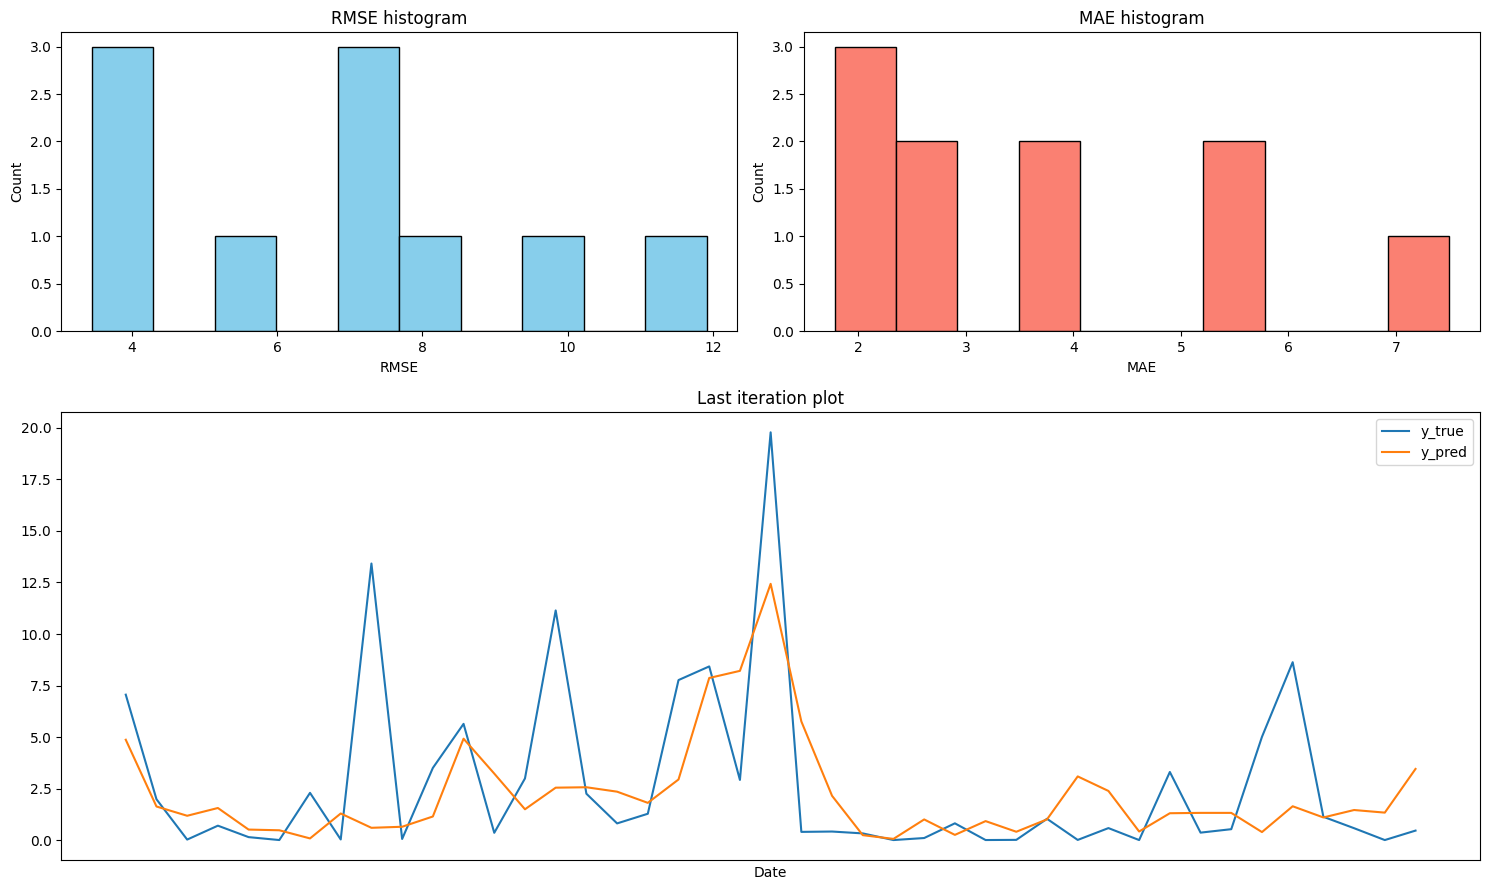

In [ ]:
cross_validation(knn_cg, X_cg_train, y_cg_train)

Evaluation 0:
+------------+------+------+------+
|            | Size | RMSE | MAE  |
+------------+------+------+------+
|   Train    |  51  | 2.81 | 1.58 |
| Validation |  43  | 4.62 | 3.63 |
+------------+------+------+------+

Evaluation 1:
+------------+------+-------+------+
|            | Size | RMSE  | MAE  |
+------------+------+-------+------+
|   Train    |  94  | 2.35  | 1.38 |
| Validation |  43  | 10.34 | 6.79 |
+------------+------+-------+------+

Evaluation 2:
+------------+------+------+------+
|            | Size | RMSE | MAE  |
+------------+------+------+------+
|   Train    | 137  | 2.76 | 1.79 |
| Validation |  43  | 6.47 | 3.35 |
+------------+------+------+------+

Evaluation 3:
+------------+------+------+------+
|            | Size | RMSE | MAE  |
+------------+------+------+------+
|   Train    | 180  | 2.63 | 1.73 |
| Validation |  43  | 5.66 | 2.64 |
+------------+------+------+------+

Evaluation 4:
+------------+------+------+------+
|            | Size 

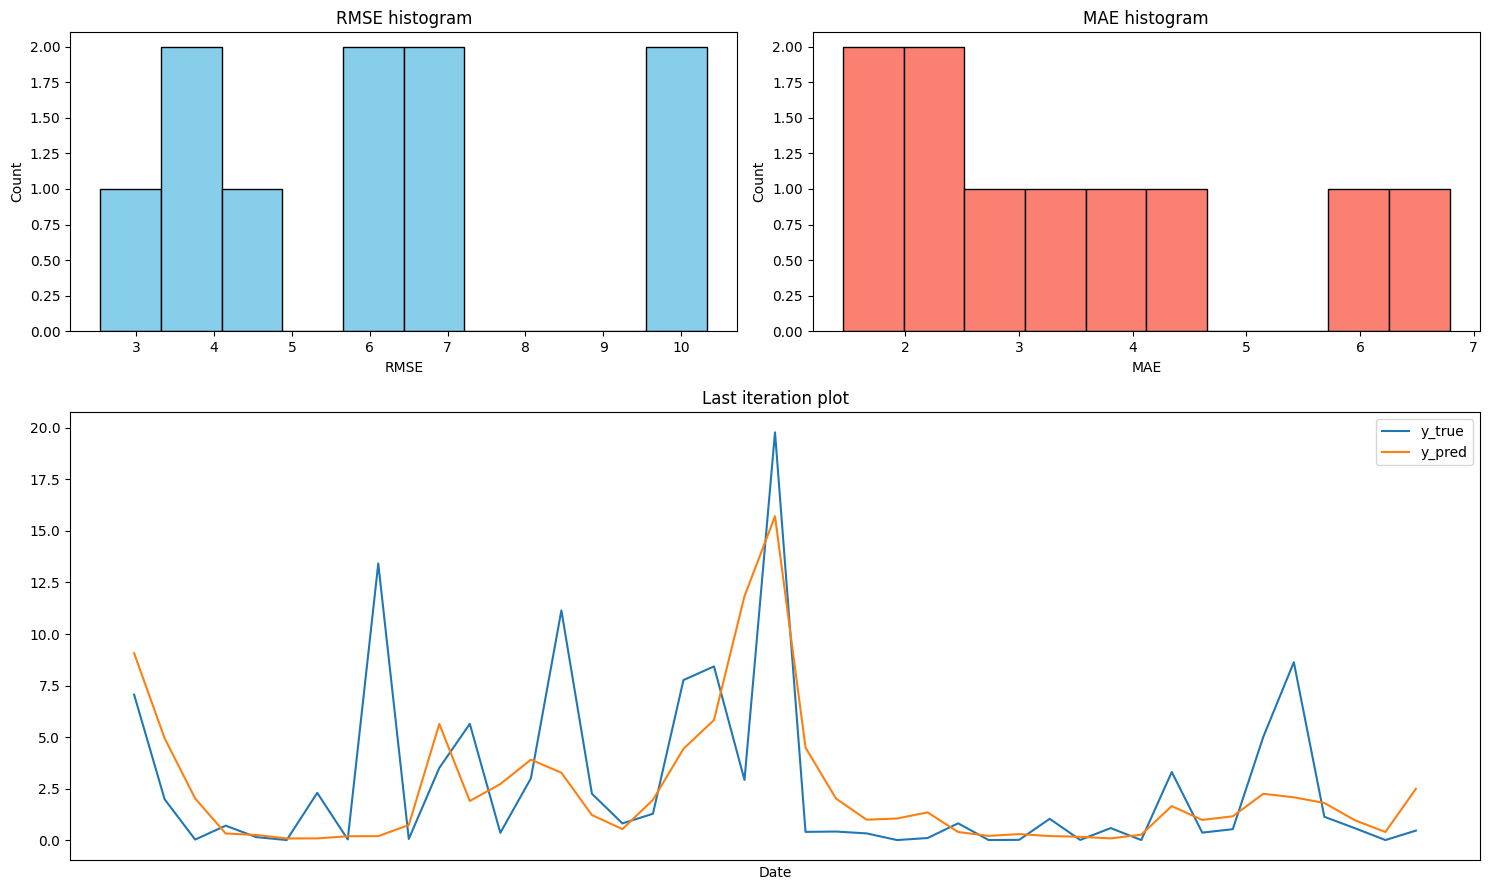

In [ ]:
cross_validation(rf_cg, X_cg_train, y_cg_train)

In [ ]:
cross_validation(xgb_cg, X_cg_train, y_cg_train)

### Test scores

#### Without cfs and gefs

In [ ]:
test(knn, X_train, X_test, y_train, y_test)

Test RMSE: 4.34
Test  MAE: 3.32


In [ ]:
test(rf, X_train, X_test, y_train, y_test)

Test RMSE: 4.11
Test  MAE: 3.17


In [ ]:
test(xgb, X_train, X_test, y_train, y_test)

Test RMSE: 3.98
Test  MAE: 2.98


#### With cfs and gefs

In [ ]:
test(knn_cg, X_cg_train, X_cg_test, y_cg_train, y_cg_test)

Test RMSE: 4.09
Test  MAE: 2.42


In [ ]:
test(rf_cg, X_cg_train, X_cg_test, y_cg_train, y_cg_test)

Test RMSE: 4.32
Test  MAE: 2.53


In [ ]:
test(xgb_cg, X_cg_train, X_cg_test, y_cg_train, y_cg_test)

Test RMSE: 3.97
Test  MAE: 2.59
